# Question 3.3 Which agricultural variable is affecting corn **grain moisture**? What is the importance of P relatively to other variables?

In this notebook, we aim at assessing the linear effect of agricultural conditions, including the P dosage, on **grain moisture**.

## Load data

Load data exported from the preprocessing session.

In [1]:
load("output/preprocessed.RData")

## Load packages

We obviously need the **`tidyverse`** package for data manipulation and plotting. **`ggthemes`** provides themes for plots. The **`nlme`** package is used for the linear mixted model. The **`broom`** package is used to create tidied **`nlme`** outputs.

In [2]:
library("tidyverse")
library("broom")
library("ggthemes")
library("nlme")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse




## Preparation to modeling

We select the variables to be included in the model.

In [3]:
var_mm <- c(soil_vars, weather_vars, "doseP", "P.Source")
data_mm <- data_rs[c("ID", "Year", "grainmoisture_perc", var_mm)]

Filter out missing data.

In [4]:
data_mm <- data_mm %>%
  drop_na() %>%
  droplevels()

Data left for modelling:

In [5]:
print(paste('Number of lines:', nrow(data_mm)))
print(paste('Number of trials:', nlevels(data_mm$ID)))

[1] "Number of lines: 736"
[1] "Number of trials: 288"


## Linear model

We begin by scaling all variables by removing the mean and dividing by the standard deviation. This assures that the effects (slopes) of the model can be compared.

In [6]:
scaled_num <- data_mm %>% 
  select(-ID, -Year, -is_manure, -grainmoisture_perc, -P.Source) %>%
  scale() %>%
  as_tibble()
data_mm_sc <- bind_cols(data_mm %>% select(ID, Year, is_manure, grainmoisture_perc, P.Source), scaled_num)

We launch split the procedure in two parts, **with and without manure**, which are datasets conducted under different methodologies. Then we run a frequential linear mixed model for each on them, then arrange the table for ploting.

In [7]:
mm_lin <- data_mm_sc %>%
  split(.$is_manure) %>%
  map(~ intervals(lme(as.formula(paste("grainmoisture_perc ~ ", paste(var_mm[var_mm != "is_manure"], collapse=" + "),
                               "+ doseP:Soil_P.Al")),
            random = ~ 1|Year/ID,
            data = .))$fixed) %>%
  map_dfr(~tidy(.), .id = 'is_manure') %>%
  rename(Variable = .rownames) %>%
  filter(Variable != "(Intercept)") %>%
  mutate(is_manure = ifelse(is_manure, "With manure", "Without manure"),
         Category = c("Soil chemistry", "Soil chemistry",
                      "Soil gensis", "Soil gensis",
                      "Soil texture", "Soil texture", "Soil texture",
                      "Weather", "Weather", "Weather",
                      "Dose",
                      "Dose","Dose","Dose",
                      "Dose",
                      "Soil chemistry", "Soil chemistry",
                      "Soil gensis", "Soil gensis",
                      "Soil texture", "Soil texture", "Soil texture",
                      "Weather", "Weather", "Weather",
                      "Dose",
                      "Dose",
                      "Dose"))

Warning message:
“'tidy.matrix' is deprecated.
See help("Deprecated")”
Warning message:
“'tidy.matrix' is deprecated.
See help("Deprecated")”


Variables are renamed to readable string.

In [8]:
for (i in 1:nrow(translate_col)) {
  mm_lin$Variable <- sub(pattern = translate_col$from_name_mm[i], 
                                 replacement = translate_col$to_name_mm_long_en[i],
                                 x = mm_lin$Variable)
}

We plot the slopes and their confidence interval.

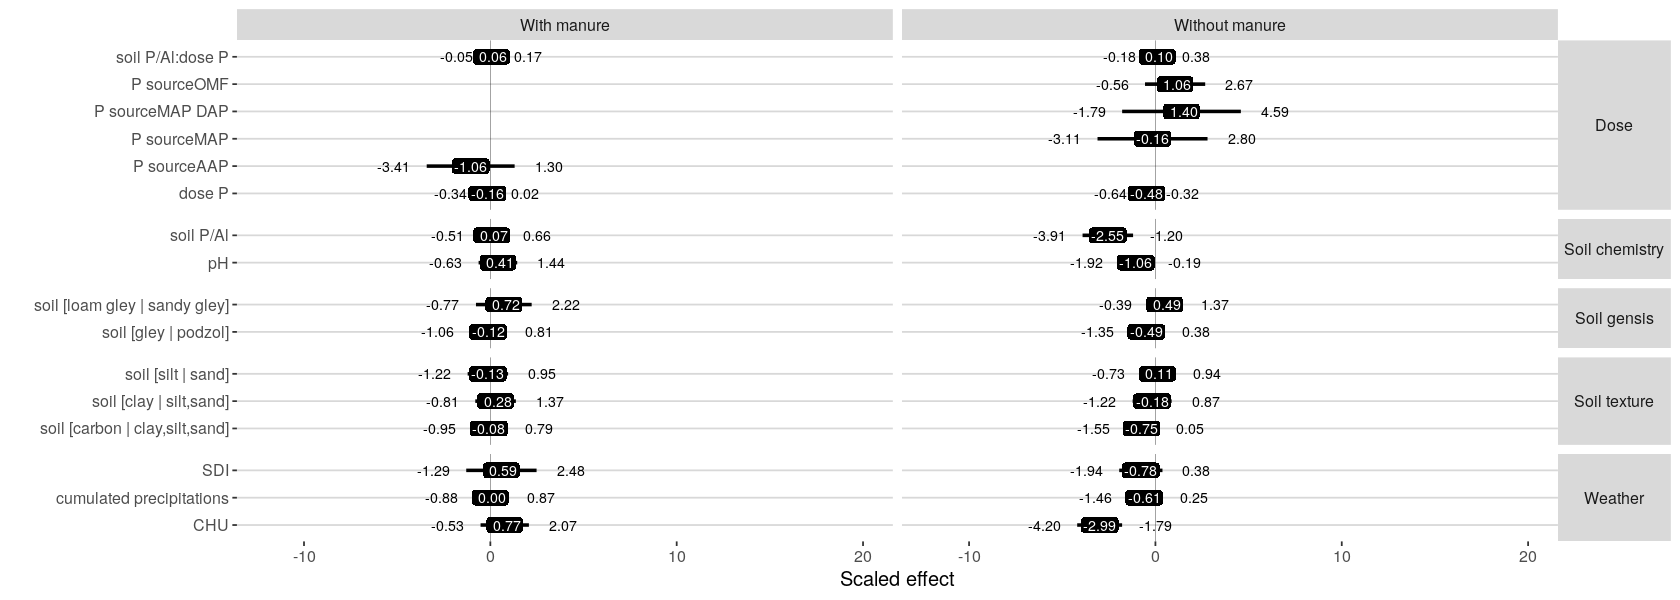

In [9]:
options(repr.plot.width = 14, repr.plot.height = 5)
mm_lin %>%
  ggplot() +
  geom_vline(xintercept = 0, lwd = 0.1) +
  geom_segment(aes(x = lower, xend = upper, y = Variable, yend = Variable), lwd = 1) +
  geom_label(aes(x = `est.`, y = Variable, label = format(round(est., 2), nsmall = 2)),
             size = 3, label.padding = unit(0.1, "lines"), colour = "white", fill = "black", label.size = 0) +
  geom_text(aes(x = lower, y = Variable, label = format(round(lower, 2), nsmall = 2)), size = 3, hjust = 1.5) +
  geom_text(aes(x = upper, y = Variable, label = format(round(upper, 2), nsmall = 2)), size = 3, hjust = -0.5) +
  facet_grid(Category ~ is_manure, scales = "free_y", space = "free_y") +
  labs(x = "Scaled effect", y = "") +
  expand_limits(x=c(-12, 20)) +
  theme_hc() +
  theme(strip.text.y = element_text(angle = 0))

In [10]:
ggsave("images/moisture_linmod.jpg", height = 5, width = 14, dpi = 600)

If we would want absolute effects, we use the dataset `data_mm` instead of `data_mm_sc`.

In [11]:
mm_lin_abs <- data_mm %>%
  split(.$is_manure) %>%
  map(~ intervals(lme(as.formula(paste("grainmoisture_perc ~ ", paste(var_mm[var_mm != "is_manure"], collapse=" + "),
                               "+ doseP:Soil_P.Al")),
            random = ~ 1|Year/ID,
            data = .), which = "fixed")$fixed) %>%
  map_dfr(~tidy(.), .id = 'is_manure') %>%
  rename(Variable = .rownames) %>%
  filter(Variable != "(Intercept)") %>%
  mutate(uncertainty = est.-lower)

Warning message:
“'tidy.matrix' is deprecated.
See help("Deprecated")”
Warning message:
“'tidy.matrix' is deprecated.
See help("Deprecated")”


Variables are renamed to readable string.

In [12]:
for (i in 1:nrow(translate_col)) {
  mm_lin_abs$Variable <- sub(pattern = translate_col$from_name_mm[i], 
                                 replacement = translate_col$to_name_mm_long_en[i],
                                 x = mm_lin_abs$Variable)
}

In [13]:
mm_lin_abs

is_manure,Variable,lower,est.,upper,uncertainty
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,pH,-3.345071865,-1.840001e+00,-0.334930961,1.505070452
FALSE,soil P/Al,-18.729045874,-1.233537e+01,-5.941692191,6.393676841
FALSE,soil [gley | podzol],-0.962030376,-3.470484e-01,0.267933591,0.614981983
FALSE,soil [loam gley | sandy gley],-0.216952813,2.700272e-01,0.757007261,0.486980037
FALSE,"soil [carbon | clay,silt,sand]",-4.117151650,-1.985730e+00,0.145690879,2.131421264
FALSE,"soil [clay | silt,sand]",-1.294017329,-1.864350e-01,0.921147242,1.107582285
FALSE,soil [silt | sand],-1.359353271,1.979029e-01,1.755158977,1.557256124
FALSE,SDI,-60.238723766,-2.425709e+01,11.724540644,35.981632205
FALSE,CHU,-0.017229243,-1.228265e-02,-0.007336049,0.004946597


**Without manure**, each kg of P per ha had *decreased* grain moisture by 0.048 +/- 0.016 %. A dosage of 40 kg/ha had thus increased grain moisture by 1.92 +/- 0.64 % compared to control.

**With manure**, each kg of P per ha had *decreased* grain moisture by 0.018 +/- 0.020 %. A dosage of 40 kg/ha had thus increased grain moisture by 0.72 +/- 0.80 % compared to control.